## Imports

In [28]:
import os
import shutil
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from Bio import SeqIO

# Custom functions
python_dir_path = os.path.join('..', 'scripts', 'python')
sys.path.append(python_dir_path)
from subset_pr2_database import run_gblocks_grid_search, move_search_grid_files, alignment_stats
from toolbox import num_seqs

## Variables

In [33]:
project = 'Suthaus_2022'
marker = 'Full18S'
sim = 'sim90'
denoise_method = 'RAD'
raw_data = os.path.join('..', 'raw_data')
subset_align_dir = os.path.join(raw_data, 'reference_alignments', 'pr2_subset')
results = os.path.join('..', 'results')

# Extracting and trimming the sequence names from the alignment

The current sequence names are too long if using Gblocks, so we can trim them before we go further. We can trim the taxopath and keeping the ID. Also, we can keep the taxapath in the separate file (sequence_full_names.txt) as we will need the taxopath later during the phylogenetic placement.

## Extracting the full sequence names from the MAFFT alignment

In [5]:
input_file = os.path.join(subset_align_dir, 'pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft.fasta')
output_file = os.path.join(subset_align_dir, 'sequence_full_names.txt')

# Open the input file for reading and output file for writing
with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    # Read through each line in the input file
    for line in infile:
        # If the line starts with '>', it's a header line
        if line.startswith('>'):
            # Write the line to the output file, excluding the '>' and trimming whitespace
            outfile.write(line[1:].strip() + '\n')  # write the id without '>' and add a newline

## Trimming the names in the MAFFT alignment

In [8]:
input_file = os.path.join(subset_align_dir, 'pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft.fasta')
output_file = os.path.join(subset_align_dir, 'pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames.fasta')

# Open the input file, parse sequences, modify IDs, and write to output file
with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    # Iterate over each record in the input file
    for record in SeqIO.parse(infile, "fasta"):
        # Split the ID at the '.' character and keep only the first part
        new_id = record.id.split(';tax=')[0]
        # Update the record's ID with the new ID
        record.id = new_id
        record.description = new_id  # Update the description to match the new ID
        # Write the modified record to the output file
        SeqIO.write(record, outfile, "fasta")

# Gblocks: masking poorly aligned positions

Gblocks eliminates poorly aligned positions and divergent regions of a DNA/protein alignment. Our alignment has many gap positions as the sequences represent taxa across all eukaryotes. This resulted in alignment with many poorly aligned positions, gaps, and highly variable positions. To mitigate this situation, we can **use Gblocks to mask the dubiously aligned positions and keep the more conservative ones**.
There are multiple parameters affecting the resulting masking in Gblocks. As these parameters are essential, I provided the simplified guide to them: https://github.com/wRajter/pacbio_diversity_assessment/tree/master/gblocks_parameters_explained.md, but you can also refer to the official documentation that is the best source: https://home.cc.umanitoba.ca/~psgendb/doc/Castresana/Gblocks_documentation.html.

## Creating a grid of parameters

As there are multiple parameters that can have differen effect on the resulting alignment, we can try out a range of parameter settings and then compare the resulting alignments. In this way, we can empirically determine which parameter settings work best for our data, and get an idea of how varying those parameters can impact the resulting alignment.

In [13]:
## Define the Parameter Range
# Defining the range of values we want to explore for each parameter
mafft_alignment = os.path.join(subset_align_dir, 'pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames.fasta')
gblocks_path = os.path.join(raw_data, 'packages', 'Gblocks_0.91b', 'Gblocks')

# Number of sequences and half of the sequences in the alignemnt as a baseline for Gblocks parameters
num_seqs_ = num_seqs(mafft_alignment)
print(f'Total number of sequences in the alignment: {num_seqs_}')
half_num_seqs = math.floor(num_seqs_ / 2) + 1 # half of the sequences, rounded down
print(f'Half of the sequences in the alignment (rounded down): {half_num_seqs}')

# b1
# Description: Minimum Number of Sequences for a Conserved Position
# Minimum is half of the sequences in the alignment.
step_size_b1 = 20
start_b1 = 0
stop_b1 = step_size_b1 * 10
b1_values = [half_num_seqs + i for i in range(start_b1, stop_b1, step_size_b1)]

# b2
# Description: Minimum Number Of Sequences For A Flank Position.
# The lower limit for b2 is the value you set for b1.
step_size_b2 = 20
start_b2 = 0
stop_b2 = step_size_b2 * 10
b2_values = [half_num_seqs + i for i in range(start_b2, stop_b2, step_size_b2)]

# b3:
# Description: Maximum Number Of Contiguous Nonconserved Positions.
# Setting this value too high can include regions of the alignment that are too variable, 
# whereas setting it too low can exclude potentially informative parts of the alignment.
# Default = 8.
step_size_b3 = 5
start_b3 = 8
stop_b3 = (step_size_b3 * 10) + start_b3
b3_values = list(range(start_b3, stop_b3, step_size_b3))

# b4:
# Description: Minimum Length Of A Block.
# Any block that's shorter than the number set will be excluded from the final alignment.
# Default = 10.
step_size_b4 = 5
start_b4 = 10
stop_b4 =  (step_size_b4 * 10) + start_b4
b4_values = list(range(start_b4, stop_b4, step_size_b4))

# v5
# Description: Allowed Gap Positions.
# a: all gaps allowed (the most relaxed setting)
# h: half (a balanced approach)
# n: no gaps allowed (the most strict setting)
b5_values = ['a', 'h', 'n']

print(f'''
b1: {b1_values}
b2: {b2_values}
b3: {b3_values}
b4: {b4_values}
b5: {b5_values}
''')

Total number of sequences in the alignment: 1371
Half of the sequences in the alignment (rounded down): 686

b1: [686, 706, 726, 746, 766, 786, 806, 826, 846, 866]
b2: [686, 706, 726, 746, 766, 786, 806, 826, 846, 866]
b3: [8, 13, 18, 23, 28, 33, 38, 43, 48, 53]
b4: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
b5: ['a', 'h', 'n']



In [19]:
# Run Grid Search
run_gblocks_grid_search(mafft_alignment = mafft_alignment,
                        b1_values = b1_values,
                        b2_values = b2_values,
                        b3_values = b3_values,
                        b4_values = b4_values,
                        b5_values = b5_values,
                        gblocks_path = gblocks_path)
# Move all the output files to the separate 'grid_search' directory
move_search_grid_files(directory_path = subset_align_dir, 
                       grid_search_path = os.path.join(subset_align_dir, 'grid_search'))

In [22]:
# Checking some basic statistics about our MAFFT alignment

search_grid_dir = os.path.join(subset_align_dir, 'grid_search')
fasta_files = [fasta for fasta in os.listdir(search_grid_dir) if '.fasta' in fasta and '_a_' in fasta]

for fasta_file in fasta_files:
    alignment_path = os.path.join(search_grid_dir, fasta_file)
    parameters = fasta_file.split('grid_')[1].strip('.fasta')
    print(f'Paramters: {parameters}')
    num_sequences, alignment_length, average_gaps, percentage_gaps, percentage_identity = alignment_stats(alignment_file = alignment_path)
    print(f"Number of sequences: {num_sequences}")
    print(f"Alignment length: {alignment_length}")
    print(f"Average number of gaps per sequence: {average_gaps:.2f}")
    print(f"Percentage of gaps across the sequences: {percentage_gaps:.2f}%")
    print(f"Average percentage identity: {percentage_identity:.2f}%")
    print('\n')

Paramters: _6
Number of sequences: 1371
Alignment length: 3742
Average number of gaps per sequence: 2423.69
Percentage of gaps across the sequences: 64.77%
Average percentage identity: 92.67%


Paramters: _4
Number of sequences: 1371
Alignment length: 3123
Average number of gaps per sequence: 1859.76
Percentage of gaps across the sequences: 59.55%
Average percentage identity: 92.18%


Paramters: _7
Number of sequences: 1371
Alignment length: 3959
Average number of gaps per sequence: 2635.44
Percentage of gaps across the sequences: 66.57%
Average percentage identity: 92.86%


Paramters: _0
Number of sequences: 1371
Alignment length: 1638
Average number of gaps per sequence: 555.42
Percentage of gaps across the sequences: 33.91%
Average percentage identity: 89.01%


Paramters: _3
Number of sequences: 1371
Alignment length: 2902
Average number of gaps per sequence: 1636.27
Percentage of gaps across the sequences: 56.38%
Average percentage identity: 91.70%


Paramters: _2
Number of sequenc

In [23]:
search_grid_dir = os.path.join(subset_align_dir, 'grid_search')
fasta_files = [fasta for fasta in os.listdir(search_grid_dir) if '.fasta' in fasta and '_a_' in fasta]
results = []

for fasta_file in fasta_files:
    metrics = alignment_stats(os.path.join(search_grid_dir, fasta_file))
    b5_value = fasta_file.split("_grid_")[1].split("_")[0]
    iteration_num = fasta_file.split("_grid_")[1].split("_")[1].strip('.fasta')
    results.append((b5_value, iteration_num) + metrics)

In [24]:
# Create a dataframe from the grid results
grid_df = pd.DataFrame(results, columns=['b5_value', 
                                         'iteration_num', 
                                         'num_sequences', 
                                         'alignment_length', 
                                         'avg_num_gaps', 
                                         'percentage_gaps', 
                                         'avg_percentage_identity'])
# Sort the dataframe based on the iteration number
grid_df = grid_df.sort_values(by='iteration_num').reset_index(drop=True)

# Add the values from the Gblocks parameters
grid_df['b1_value'] = b1_values
grid_df['b2_value'] = b2_values
grid_df['b3_value'] = b3_values
grid_df['b4_value'] = b4_values

In [25]:
grid_df

,b5_value,iteration_num,num_sequences,alignment_length,avg_num_gaps,percentage_gaps,avg_percentage_identity,b1_value,b2_value,b3_value,b4_value
0,a,0,1371,1638,555.422319,33.908567,89.008584,686,686,8,10
1,a,1,1371,2100,949.944566,45.235456,90.088500,706,706,13,15
2,a,2,1371,2634,1401.421590,53.205072,91.331115,726,726,18,20
3,a,3,1371,2902,1636.266229,56.384088,91.701188,746,746,23,25
4,a,4,1371,3123,1859.762947,59.550527,92.177144,766,766,28,30
5,a,5,1371,3524,2243.625821,63.667021,92.441886,786,786,33,35
6,a,6,1371,3742,2423.685631,64.769792,92.670072,806,806,38,40
7,a,7,1371,3959,2635.440554,66.568339,92.860334,826,826,43,45
8,a,8,1371,4171,2828.388767,67.810807,93.053806,846,846,48,50
9,a,9,1371,4419,3133.550693,70.910855,93.569146,866,866,53,55


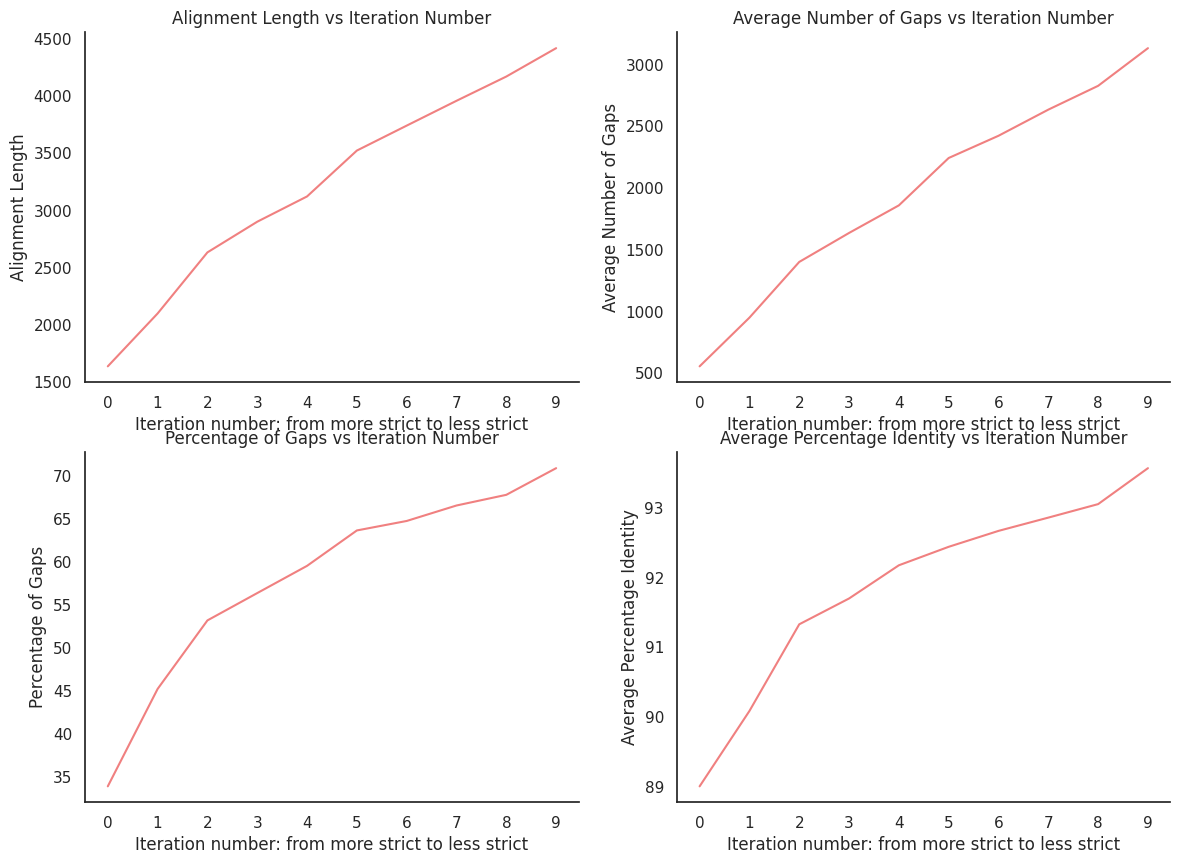

In [34]:
# Visualization

# Set style of seaborn plot
sns.set(style="white")

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define the metrics and their respective labels
metrics = ['alignment_length', 'avg_num_gaps', 'percentage_gaps', 'avg_percentage_identity']
labels = ['Alignment Length', 'Average Number of Gaps', 'Percentage of Gaps', 'Average Percentage Identity']

# Iterate over each metric and plot it in its subplot
for ax, metric, label in zip(axes.ravel(), metrics, labels):
    sns.lineplot(x='iteration_num', y=metric, data=grid_df, color='lightcoral', ax=ax)
    ax.set_title(label + ' vs Iteration Number')
    ax.set_xlabel('Iteration number: from more strict to less strict')
    ax.set_ylabel(label)
    # Set visibility for spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

# Adjust layout for better spacing
# plt.tight_layout()
# plt.show()

# save path
save_path = os.path.join(results, 'reference_alignment', 'pr2_ref_align_gblocks_grid_search.png')
# Save the figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Alignment selection

Based on the Gblocks results, I will continue with three alignments:
 - pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_0.fasta = **reference_alignment_gblocksStrict.fasta**
 - pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_4.fasta = **reference_alignment_gblocksModerate.fasta** 
 - pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_9.fasta = **reference_alignment_gblocksLoose.fasta**

In [29]:
# Copy and rename the chosen alignments to the reference alignments
search_grid_dir = os.path.join(subset_align_dir, 'grid_search')
# Source files
source_strict_alignment = os.path.join(search_grid_dir, 'pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_0.fasta')
source_moderate_alignment = os.path.join(search_grid_dir, 'pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_4.fasta')
source_loose_alignment = os.path.join(search_grid_dir, 'pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_9.fasta')
# Destination files
dest_strict_alignment = os.path.join(subset_align_dir, 'reference_alignment_gblocksStrict.fasta')
dest_moderate_alignment = os.path.join(subset_align_dir, 'reference_alignment_gblocksModerate.fasta')
dest_loose_alignment = os.path.join(subset_align_dir, 'reference_alignment_gblocksLoose.fasta')
# Putting the source and destination files into lists
src = [source_strict_alignment, source_moderate_alignment, source_loose_alignment]
dst = [dest_strict_alignment, dest_moderate_alignment, dest_loose_alignment]

# Copy and rename
for i in range(len(src)):
    source_file = src[i]
    destination_file = dst[i]
    shutil.copyfile(source_file, destination_file)
    print(f'Source file {source_file}\nwas renamed to: {destination_file}\n')

Source file ../raw_data/reference_alignments/pr2_subset/grid_search/pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_0.fasta
was renamed to: ../raw_data/reference_alignments/pr2_subset/reference_alignment_gblocksStrict.fasta

Source file ../raw_data/reference_alignments/pr2_subset/grid_search/pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_4.fasta
was renamed to: ../raw_data/reference_alignments/pr2_subset/reference_alignment_gblocksModerate.fasta

Source file ../raw_data/reference_alignments/pr2_subset/grid_search/pr2_version_5.0.0_SSU_UTAX_euknucl_subset_mafft_shortnames_gblocks_grid_a_9.fasta
was renamed to: ../raw_data/reference_alignments/pr2_subset/reference_alignment_gblocksLoose.fasta

